In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import re
from IPython.display import HTML
pudl_engine = pudl.db_connect_pudl()
plt.style.use('ggplot')
mpl.rc('figure', figsize=(6,6))
mpl.rc('figure', dpi=150)
mpl.rc('animation', writer='ffmpeg')

# Create a pair of test datasets

In [2]:
test_noise=[0.5, 0.25, 0.5, 1.0, 0.5, 0.1, 0.3]
eia_df, ferc_df = analysis.zippertestdata(gens=100, max_group_size=5, noise=test_noise, samples=13)

# Aggregate test datasets as if they were FERC/EIA data for plotting

In [3]:
eia_pudl_df = eia_df.groupby(['pudl_plant_id','year']).agg(sum)
eia_pudl_df.columns = eia_pudl_df.columns.str.replace('series','eia')
ferc_pudl_df = ferc_df.groupby(['pudl_plant_id','year']).agg(sum)
ferc_pudl_df.columns = ferc_pudl_df.columns.str.replace('series','ferc')
both_pudl_df = ferc_pudl_df.merge(eia_pudl_df, left_index=True, right_index=True)

# Plot the aggregated test data so we can compare it with FERC/EIA
See the ferc_to_eia_plant_correlations notebook for what the real data looks like.

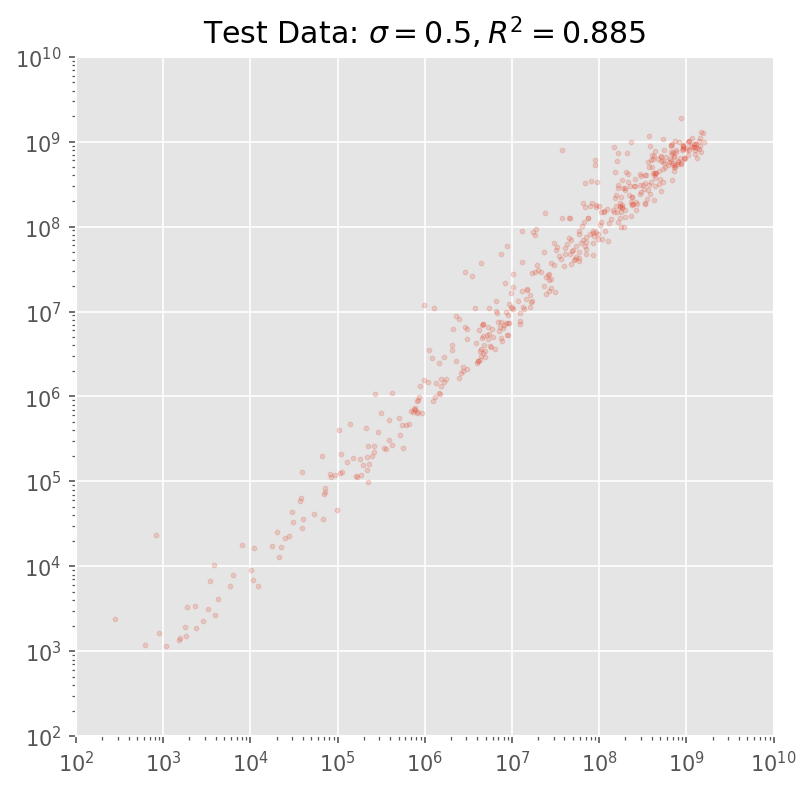

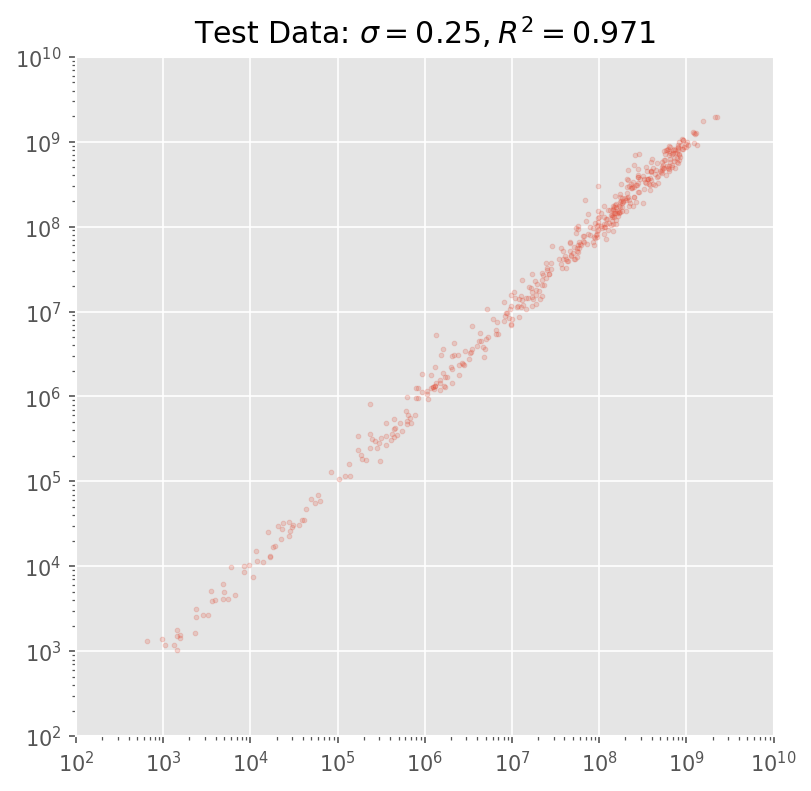

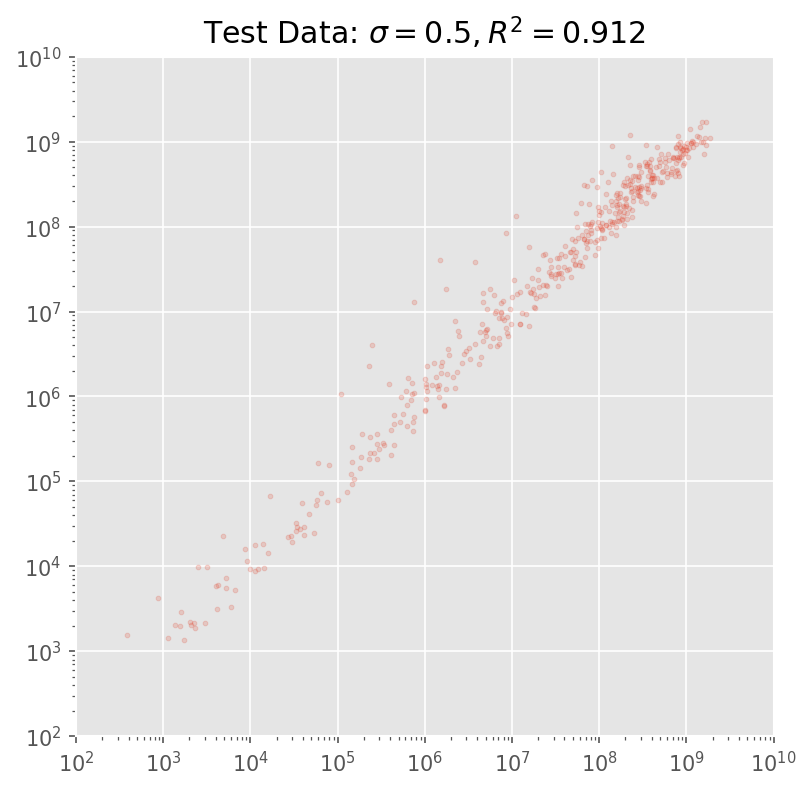

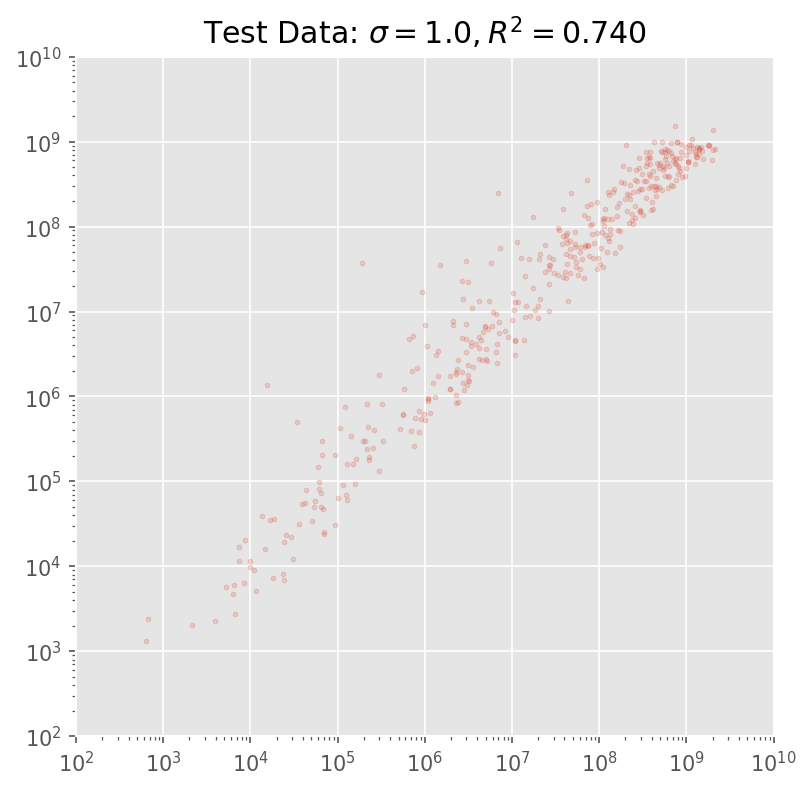

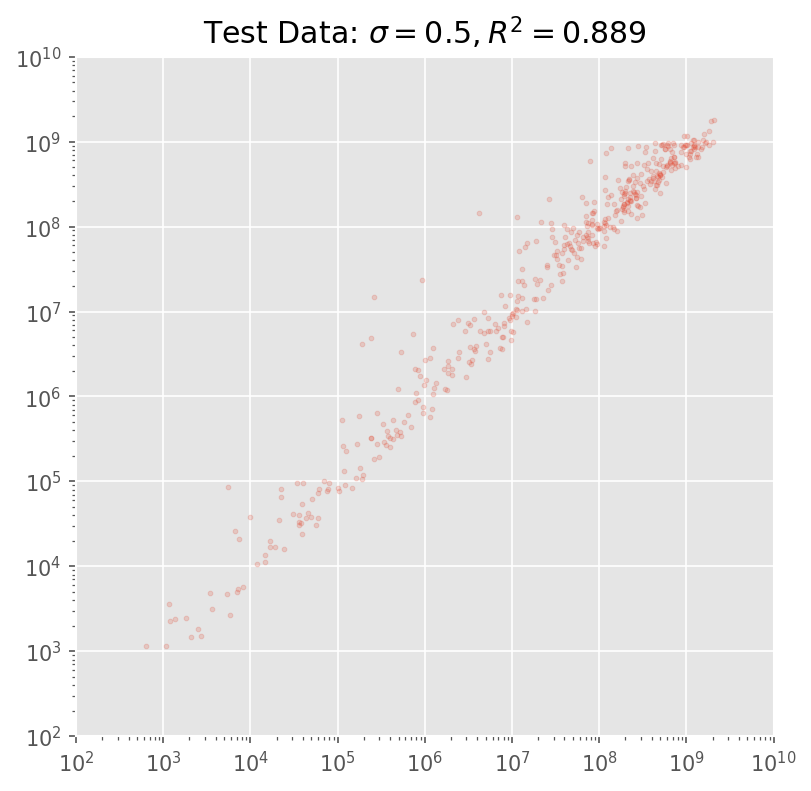

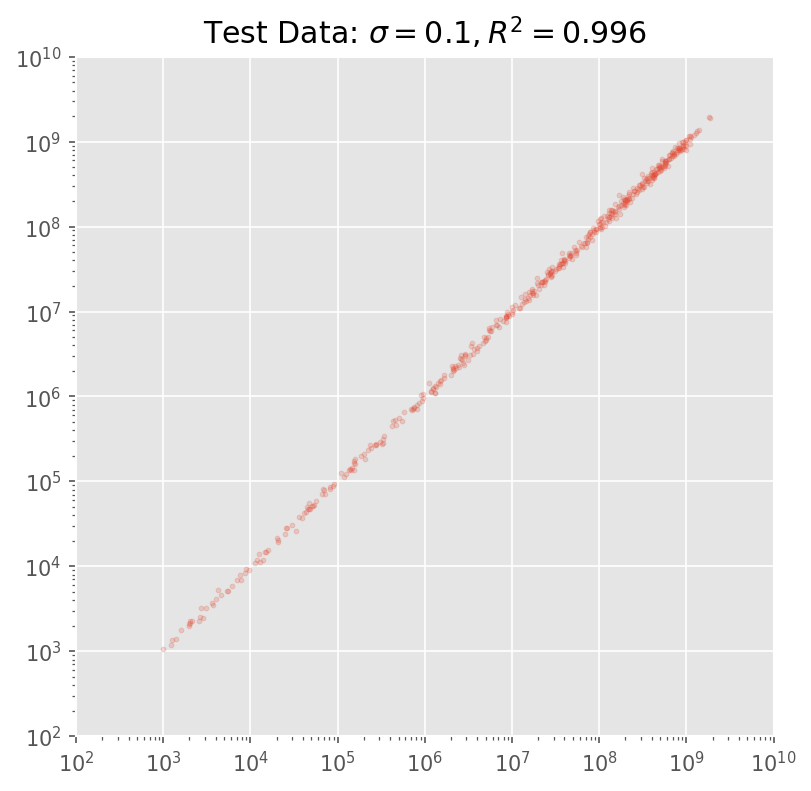

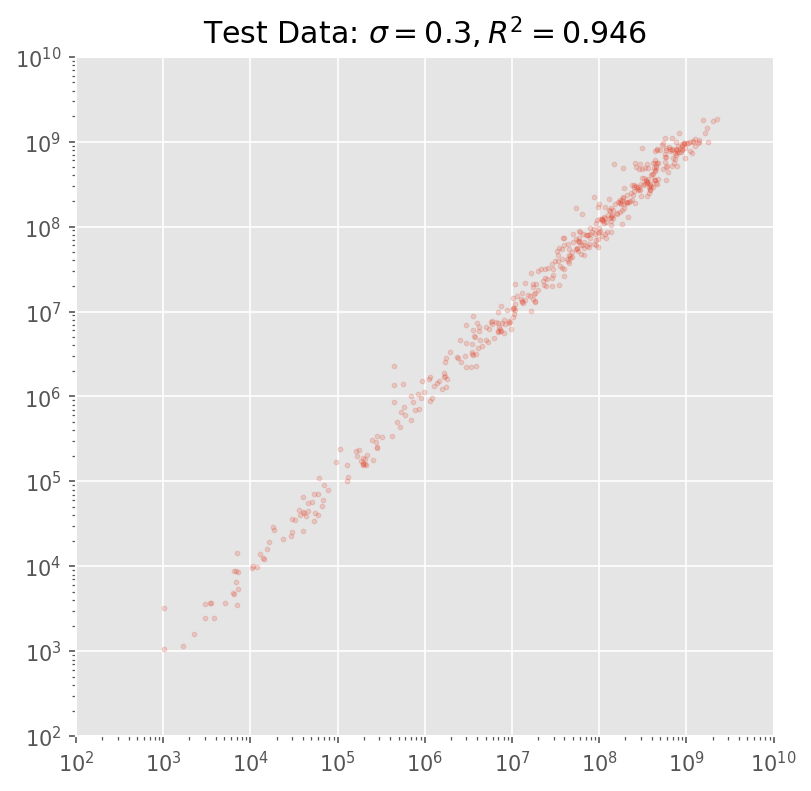

In [4]:
for N in np.arange(0,len(test_noise)):
    ferc_series = 'ferc{}'.format(N)
    eia_series = 'eia{}'.format(N)
    noise_val = test_noise[N]
    
    plt.scatter(both_pudl_df[ferc_series], both_pudl_df[eia_series], s=5, alpha=0.2)
    R_2 = np.corrcoef(both_pudl_df[ferc_series],both_pudl_df[eia_series])[0,1]
    plt.title("Test Data: $\sigma={}, R^2={:0.3f}$".format(noise_val, R_2))
    plt.xlim((1e2,1e10))
    plt.ylim((1e2,1e10))
    plt.loglog()
    plt.savefig('pudl_series_{}.png'.format(N))
    plt.show()

In [5]:
def plant_corr(pudl_df, x1, x2):
    gb = pudl_df.groupby('pudl_plant_id')
    corr = gb[[x1,x2]].corr().reset_index()
    corr = corr.drop(x2, axis=1)
    corr = corr[corr['level_1']==x2]
    corr = corr[['pudl_plant_id',x1]]
    corr = corr.rename(columns={x1:'corr'})
    corr = corr.dropna()
    return(corr)

def plot_plant_corr(corrs=[], titles=[]):
    """Given a list of DataFrames containing per-plant correlations of some variable,
    and a set of associated figure titles, create a figure displaying the distributions
    of those correlations."""
    
    nrows = len(corrs)
    assert nrows == len(titles)
    fig, axes = plt.subplots(ncols=1, nrows=nrows)
    fig.set_figwidth(10)
    fig.set_figheight(4*nrows)
    fig.set_dpi(150)
    for (ax, title, corr) in zip(axes, titles, corrs):
        ax.set_xlim(0.0,1.1)
        ax.set_title(title)
        ax.set_ylabel("# of Plants")
        ax.set_xlabel("$R^2$")
        ax.grid(b=True)
        ax.hist(corr['corr']**2, bins=200, range=(0,1));
    fig.tight_layout()
    plt.show()

# Look at the distribtuion of per-plant variable correlations

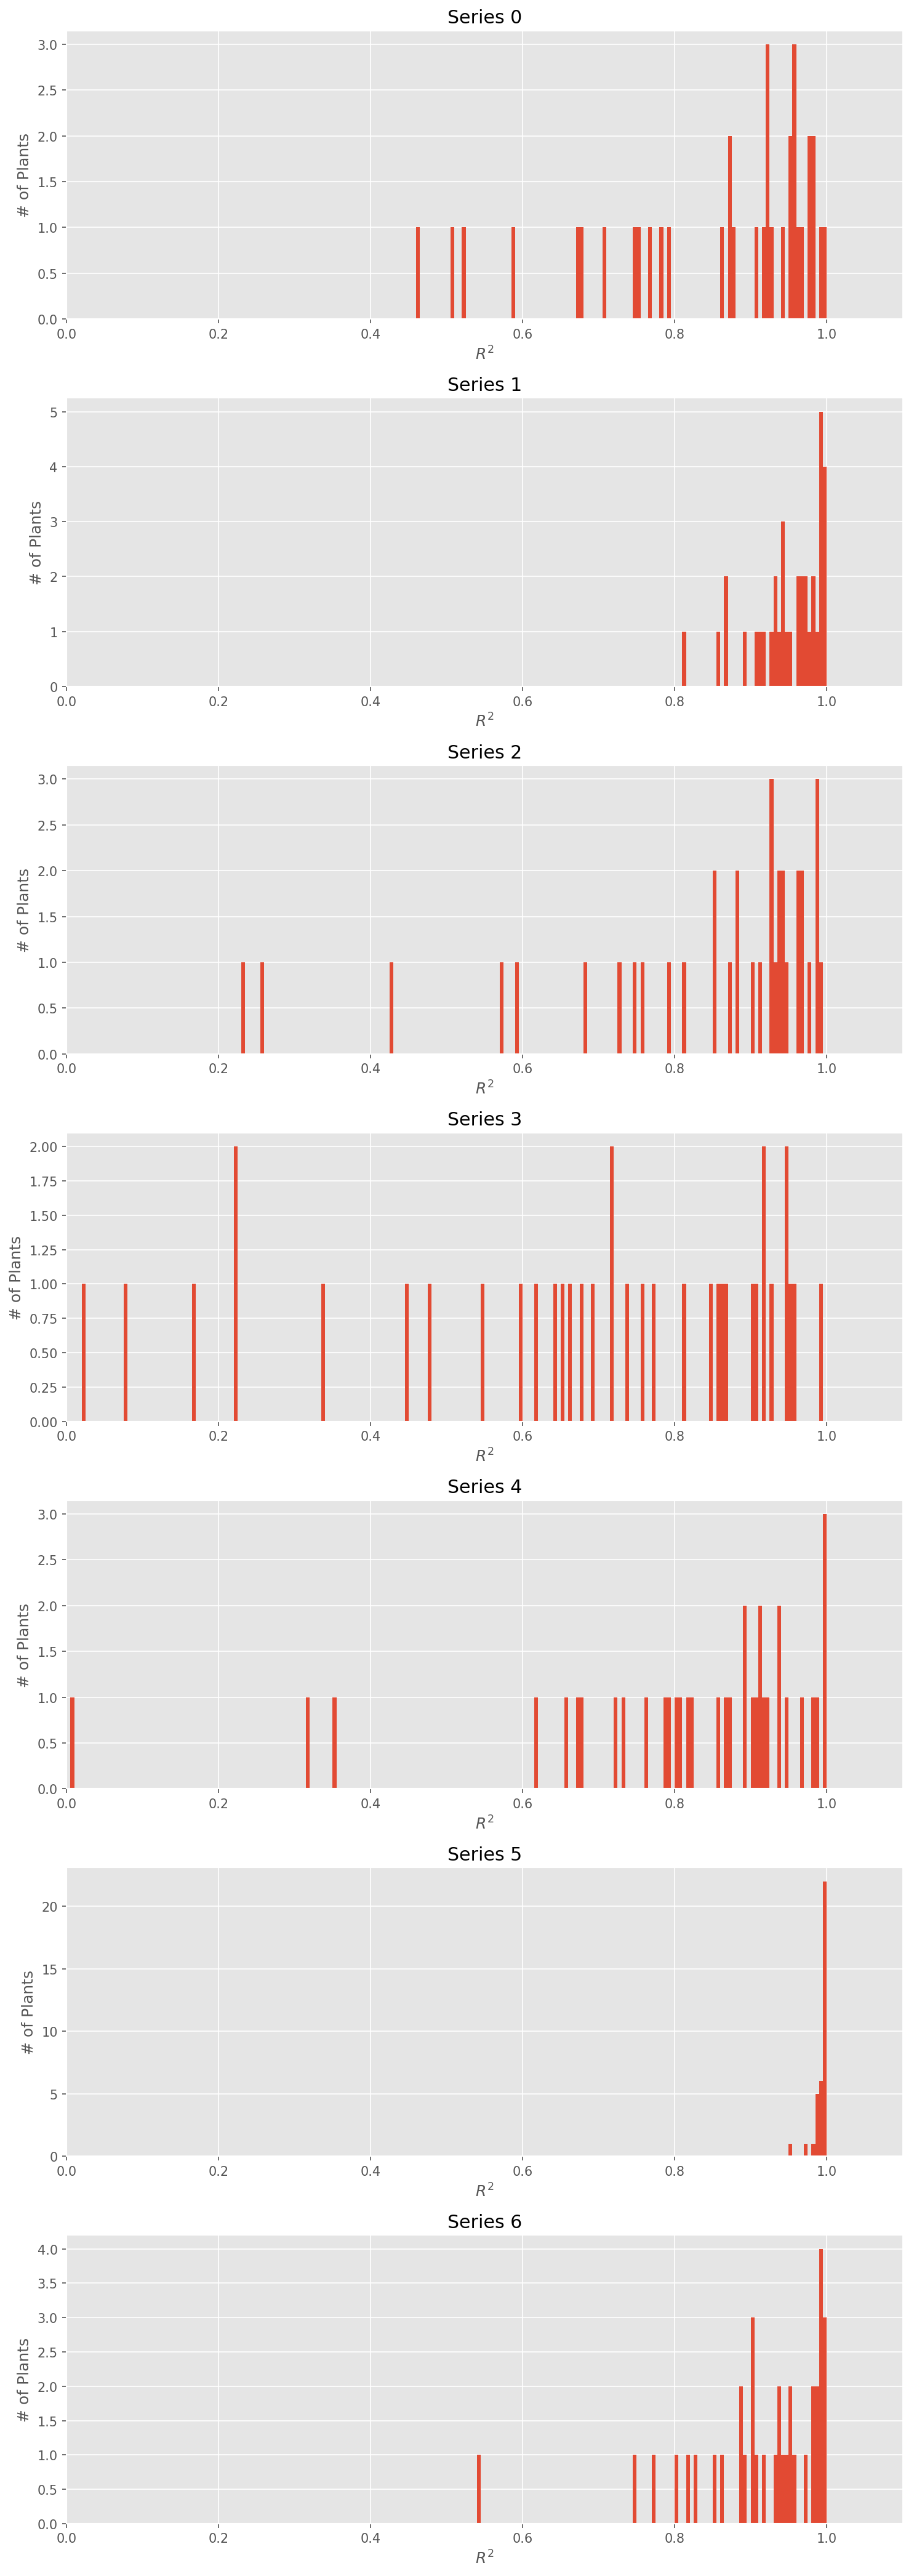

In [6]:
corrs = []
titles = []
for N in range(len(test_noise)):
    eiaN = 'eia{}'.format(N)
    fercN = 'ferc{}'.format(N)
    titleN = 'Series {}'.format(N)
    corrs = corrs + [plant_corr(both_pudl_df, eiaN, fercN),]
    titles = titles + [titleN,]
    
plot_plant_corr(corrs=corrs, titles=titles)

# Aggregate and correlate test datasets

In [7]:
agg_df = analysis.aggregate_by_pudl_plant(eia_df, ferc_df)

N_series = len(test_noise)
eia_cols = [ 'series{}_eia'.format(N) for N in range(N_series) ]
ferc_cols = [ 'series{}_ferc'.format(N) for N in range(N_series) ]
corr_cols = [ 'series{}_corr'.format(N) for N in range(N_series) ]

corr_df = analysis.correlate_by_generators(agg_df, eia_cols, ferc_cols, corr_cols)

# Score candidate generator groupings

In [8]:
winners = analysis.score_all(corr_df, corr_cols)

In [9]:
winners

,pudl_plant_id,candidate_id,mean_corr,eia_gen_subgroup,ferc_plant_id,success
0,0,0,0.881091,aa,AA,True
1,0,0,0.881091,ab,AB,True
2,0,0,0.881091,ac,AC,True
3,1,0,0.927054,ad_ae_af_ag,AD_AE_AF_AG,True
4,2,0,0.976024,ah,AH,True
5,2,0,0.976024,ai_aj,AI_AJ,True
6,3,0,0.852426,ak,AK,True
7,3,0,0.852426,al,AL,True
8,3,0,0.852426,am,AM,True
9,4,0,0.918722,an,AN,True


In [10]:
len(winners.success==True)/len(winners)

1.0